# Import

In [155]:
from parcels import (
        FieldSet,
        JITParticle,
        ScipyParticle,
        ParticleSet,
        AdvectionRK4,
        AdvectionRK4_3D,
        StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask

import numpy as np
from numpy.random import uniform, randint

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
from time import time
import warnings
import shapely


warnings.simplefilter("ignore")

# Set Parameters

In [156]:
# Parameters
RNG_seed = 123

# Time
year = 2016
start_month = 1
start_day = 1
end_month = 12
end_day = 31
max_age_d = 220
# timedirection
timearrow = 1
# Timestep in minutes
dt_in_minutes = 15
output_dt_in_minutes = 15

# Box traits
depth_m = 0

n_particles_per_cell = 10

repeated_release = True
repeatdt_d = 7

is_papermill = False


In [157]:
if not is_papermill:
        year = 2016
        start_month = 1
        start_day = 1
        end_month = 1
        end_day = 2
        max_age_d = 200
        # timedirection
        timearrow = 1
        # Timestep in minutes
        dt_in_minutes = 6*60
        output_dt_in_minutes = 12*60

        # algae_

        # Box traits
        depth_m = 0

        n_particles_per_cell = 100

        repeated_release = False
        repeatdt_d = 7

# Read Files

In [158]:
# Get Variables from Parameters
start_date = np.datetime64(f"{year}-{start_month:02d}-{start_day:02d}", "D")
end_date = np.datetime64(f"{year}-{end_month:02d}-{end_day:02d}", "D")
first_day_in_year = np.datetime64(f"{year}-01-01", "D")

first_file_count = (start_date - first_day_in_year).astype(int) * 4
if first_file_count > 0:
        first_file_count -= 1

last_file_count = (end_date - first_day_in_year + 1).astype(int) * 4 + 1

runtime_in_days = (end_date - start_date).tolist()
dt_min = np.timedelta64(dt_in_minutes, "m").tolist()
dt_out_min = np.timedelta64(output_dt_in_minutes, "m").tolist()

np.random.seed(RNG_seed)
save_path = f"/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/{year}/"

## Get file names 

In [159]:
# establish folder paths
path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
path_static_fine = path_static_files / "static_file_fine"
path_static_coarse = path_static_files / "static_file_coarse"

# get static file paths
sigma_file_fine = path_static_fine / "sigma_file_fine.nc"
lonlat_file_fine = path_static_fine / "lonlat_file_fine.nc"

sigma_file_coarse = path_static_coarse / "sigma_file_coarse.nc"
lonlat_file_coarse = path_static_coarse / "lonlat_file_coarse.nc"

# get file list paths
current_files_fine = sorted(path_orig_files.glob(f"c_file_fine_{year}/*"))[first_file_count:last_file_count]
salt_temp_fine = sorted(path_orig_files.glob(f"t_file_fine_{year}/*"))[first_file_count:last_file_count]

current_files_coarse = sorted(path_orig_files.glob(f"c_file_coarse_{year}/*"))[first_file_count:last_file_count]
salt_temp_files_coarse = sorted(path_orig_files.glob(f"t_file_coarse_{year}/*"))[first_file_count:last_file_count]

# Functions

In [160]:
def relative_position_in_cell(x_rel: float, y_rel: float, cell: shapely.Polygon):
        (x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4) = cell.exterior.coords
        ex = (x3-x0, y3-y0)
        ey = (x1-x0, y1-y0)
        return np.array(x0 + x_rel * ex[0] + y_rel * ey[0]), np.array(y0 + x_rel * ex[1] + y_rel * ey[1])

In [161]:
# Mapping parameters
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (2.5, 27.5, 52, 62)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[:2])
map_projection = ccrs.Stereographic(central_longitude=lonmid, central_latitude=latmid)
def basemap(ax):
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.gridlines(draw_labels=["left", "bottom"], y_inline=False)
        return ax

# Construct release locations

In [162]:
release_area_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/Fucus_location_shp")
gdf_release_area = gpd.read_file(Path(release_area_path,"REDLIST_SIS_Macrophytes.geojson"))

gdf_release_area = (
        gdf_release_area
        .drop(gdf_release_area[gdf_release_area.F_vesiculo==0].index)
        .to_crs(crs=ccrs.Geodetic())
        .assign(area_m2 = gdf_release_area.to_crs(crs=ccrs.AlbersEqualArea()).area)
)[["CELLCODE", "F_vesiculo", "geometry", "CELLID"]]

# if not is_papermill:
#         gdf_release_area = gdf_release_area.iloc[:23]

# Get total number of particles
n_release_cells = gdf_release_area.shape[0]
n_particles = n_release_cells * n_particles_per_cell

In [163]:
start_date_str = start_date.astype(str).replace("-","")
end_date_str = end_date.astype(str).replace("-","")

filename_time = f"{start_date_str}-{end_date_str}_dt{output_dt_in_minutes}min"
output_filename = f"Nested_{filename_time}_N{n_particles}_seed{RNG_seed}.zarr"
# define Output path and name
if is_papermill:
        output_filename = str("PPmill_" + output_filename)
else:
        output_filename = str("TEST_" + output_filename)

output_path = Path(save_path, output_filename)
print(f"{output_path}")

/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt720min_N87200_seed123.zarr


In [164]:
# pick a random cell and a random position within cell
lon, lat, cellcode, observation_period = list(
        zip(
                *[
                        relative_position_in_cell(
                                rand_x, rand_y, gdf_release_area.iloc[rand_cell].geometry
                        ) 
                        + (gdf_release_area.iloc[rand_cell].CELLCODE,)
                        + (gdf_release_area.iloc[rand_cell].F_vesiculo,)
                        for rand_x, rand_y, rand_cell in zip(
                                uniform(0, 1, size=n_particles),
                                uniform(0, 1, size=n_particles),
                                randint(0, len(gdf_release_area), size=n_particles),
                        )
                ]
        )
)

release_lons = np.array(lon)
release_lats = np.array(lat)
release_depths = np.zeros_like(release_lons)

In [11]:
# pick a random cell and a random position within cell
release_lons, release_lats, cellcode = list(
        zip(
                *[
                        relative_position_in_cell(
                                rand_x, rand_y, gdf_release_area.iloc[rand_cell].geometry
                        ) 
                        + (gdf_release_area.iloc[rand_cell].CELLCODE,)
                        for rand_x, rand_y, rand_cell in zip(
                                uniform(0, 1, size=n_particles),
                                uniform(0, 1, size=n_particles),
                                randint(0, len(gdf_release_area), size=n_particles),
                        )
                ]
        )
)

release_depths = np.zeros_like(release_lons)

# Parcels

## Custom Kernel

In [12]:
def delete_error_particle(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [13]:
def AdvectionRK4_2D_SIGMABSH(particle, fieldset, time):
        time0 = time
        sig0 = particle.depth
        lat0 = particle.lat
        lon0 = particle.lon

        (u1, v1) = fieldset.UV[time0, sig0, lat0, lon0]  # horizontal velocities in deg/s

        s1 = fieldset.S[time0, sig0, lat0, lon0]
        t1 = fieldset.T[time0, sig0, lat0, lon0]

        time1 = time0 + 0.5 * particle.dt

        lat1 = lat0 + v1 * 0.5 * particle.dt
        lon1 = lon0 + u1 * 0.5 * particle.dt

        sig1 = sig0
        (u2, v2) = fieldset.UV[time1, sig1, lat1, lon1]

        time2 = time0 + 0.5 * particle.dt
        lat2 = lat0 + v2 * 0.5 * particle.dt
        lon2 = lon0 + u2 * 0.5 * particle.dt
        
        sig2 = sig0
        (u3, v3) = fieldset.UV[time2, sig2, lat2, lon2]

        time3 = time0 + particle.dt

        lat3 = lat0 + v3 * particle.dt
        lon3 = lon0 + u3 * particle.dt

        sig3 = sig0
        (u4, v4) = fieldset.UV[time3, sig3, lat3, lon3]

        lon4 = lon0 + (u1 + 2 * u2 + 2 * u3 + u4) / 6 * particle.dt
        lat4 = lat0 + (v1 + 2 * v2 + 2 * v3 + v4) / 6 * particle.dt

        particle_dlon += lon4 - lon0
        particle_dlat += lat4 - lat0

        particle.u = u1
        particle.v = v1
        particle.S = s1
        particle.T = t1


In [14]:
Custom_kernel = [AdvectionRK4_2D_SIGMABSH, delete_error_particle]

## Fieldset

In [15]:
dim_dict_lonlat = dict(lon="lon", lat="lat")
dim_dict_lonlat_time = dict(dim_dict_lonlat, time="time")
dim_dict_lonlat_time_depth = dict(dim_dict_lonlat_time, depth="sigma")

In [16]:
# Prepare reading of variables
fieldset_variables = ["U", "V"]
variable_names = ["uvel", "vvel"]
dim_dicts = [dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth]
interp_methods = ["cgrid_velocity", "cgrid_velocity"]

variables = dict(zip(fieldset_variables, variable_names))
dimensions = dict(zip(fieldset_variables, dim_dicts))
interp_method = dict(zip(fieldset_variables, interp_methods))

### Fine Fieldsets

In [17]:
lonlat_dict_fine = dict(lon=lonlat_file_fine, lat=lonlat_file_fine)

salt_temp_dict_fine = dict(
        lonlat_dict_fine,
        depth=sigma_file_fine,
        data=salt_temp_fine,
)
current_dict_fine = dict(
        lonlat_dict_fine, 
        depth=sigma_file_fine,
        data=current_files_fine,
)

In [18]:
salt_temp_variables = dict(S="salt", T="temp")
salt_temp_dimensions = dict(S=dim_dict_lonlat_time_depth, T=dim_dict_lonlat_time_depth)
salt_temp_interp_methods = dict(S="cgrid_tracer", T="cgrid_tracer")

In [19]:
# Build fine fieldset for Temp and salinity
salt_temp_filenames_fine = dict(S=salt_temp_dict_fine, T=salt_temp_dict_fine)

salt_temp_fieldset_fine = FieldSet.from_netcdf(
        filenames=salt_temp_filenames_fine,
        variables=salt_temp_variables,
        dimensions=salt_temp_dimensions,
        interp_method=salt_temp_interp_methods,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [20]:
# Build fine fieldset for all the other Values
current_filenames_fine = dict(U=current_dict_fine, V=current_dict_fine)

fieldset_fine = FieldSet.from_netcdf(
        filenames=current_filenames_fine,
        variables=variables,
        dimensions=dimensions,
        interp_method=interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Coarse Fieldsets

In [21]:
lonlat_dict_coarse = dict(lon=lonlat_file_coarse, lat=lonlat_file_coarse)

current_dict_coarse = dict(
        lonlat_dict_coarse, 
        depth=sigma_file_coarse,
        data=current_files_coarse,
)
salt_temp_dict_coarse = dict(
        lonlat_dict_coarse,
        depth=sigma_file_coarse,
        data=salt_temp_files_coarse,
)

In [22]:
# Build coarse fieldset for Temp and salinity
salt_temp_filenames_coarse = dict(S=salt_temp_dict_coarse, T=salt_temp_dict_coarse)

salt_temp_fieldset_coarse = FieldSet.from_netcdf(
        filenames=salt_temp_filenames_coarse,
        variables=salt_temp_variables,
        dimensions=salt_temp_dimensions,
        interp_method=salt_temp_interp_methods,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [23]:
# Build coarse fieldset for all the other Values
current_filenames_coarse = dict(U=current_dict_coarse, V=current_dict_coarse)

fieldset_coarse = FieldSet.from_netcdf(
        filenames=current_filenames_coarse,
        variables=variables,
        dimensions=dimensions,
        interp_method=interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Nested fieldset

In [24]:
# Build Nested field from the fine and coarse fields
U_nested_field = parcels.NestedField("U", [fieldset_fine.U, fieldset_coarse.U])
V_nested_field = parcels.NestedField("V", [fieldset_fine.V, fieldset_coarse.V])

nested_fieldset = FieldSet(U_nested_field, V_nested_field)

S_nested_field = parcels.NestedField("S", [salt_temp_fieldset_fine.S, salt_temp_fieldset_coarse.S])
T_nested_field = parcels.NestedField("T", [salt_temp_fieldset_fine.T, salt_temp_fieldset_coarse.T])

nested_fieldset.add_field(S_nested_field)
nested_fieldset.add_field(T_nested_field)

# Create Particles

In [25]:
n_particles_cellID_list = []
for cell in cellcode:
        n_particles_cellID_list.extend(gdf_release_area[gdf_release_area.CELLCODE == cell].CELLID)

In [26]:
# Establish particle variables
particle_variables = (
        "u", "v",
        "S", "T",
)
SampleParticle = parcels.JITParticle.add_variables(particle_variables)
SampleParticle = SampleParticle.add_variable(
        parcels.Variable("CellID", initial=n_particles_cellID_list),
)

In [27]:
[start_date + np.timedelta64("12", "h")] *n_particles


[numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),
 numpy.datetime64('2016-01-01T12','h'),


In [28]:
# Build Particle Set
start_time = start_date + np.timedelta64("12", "h") 

pset = ParticleSet(
        fieldset=nested_fieldset,
        pclass=SampleParticle,
        lat=release_lats,
        lon=release_lons,
        depth=release_depths,
        time=[start_time for n in range(n_particles)],
        repeatdt=timedelta(days=repeatdt_d),
)
if not repeated_release:
    pset.repeatdt = None

In [29]:
# Define Outputparameters
output_particle_file = pset.ParticleFile(
        name=output_path,
        outputdt=dt_out_min,
        chunks=(n_particles, int(24 * 60 / output_dt_in_minutes)),
)

# Execute

In [30]:
# Execute Simulation
pset.execute(
    Custom_kernel,
    dt=dt_min,
    runtime=runtime_in_days,
    output_file=output_particle_file,
    verbose_progress=True,
)

INFO: Output files are stored in /gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt720min_N4360_seed123.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [00:59<00:00, 1458.68it/s]


# Analysis

## Read files

In [31]:
# output_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/output/Trajectories/2016/TEST_Nested_20160601-20160602_dt60min_Fehmarn exposed_d0m-25m_N100_seed123.zarr")

In [32]:
ds_traj_standard = xr.open_zarr("/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160104_dt60min_N2_seed123.zarr").compute()
ds_traj_sig_is0 = xr.open_zarr("/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt60min_N2_seed123_sig_is0_no_w_wsig.zarr")
ds_traj_sig_issig0 = xr.open_zarr("/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt60min_N2_seed123_sig_issig0_no_w_wsig.zarr")

In [33]:
ds_traj_standard = ds_traj_standard.isel(obs=slice(24))

In [34]:
ds_trajectories = xr.open_zarr(output_path).compute()
# ds_trajectories["age_day"] = (ds_trajectories.age_sec/(60*60*24)).compute()
# depth_m = ds_trajectories.eta - ds_trajectories.z * (
#     ds_trajectories.eta + ds_trajectories.h0
# )
# ds_trajectories = ds_trajectories.assign(depth=depth_m)
ds_trajectories

<xarray.Dataset> Size: 942kB
Dimensions:     (trajectory: 4360, obs: 4)
Coordinates:
  * obs         (obs) int32 16B 0 1 2 3
  * trajectory  (trajectory) int64 35kB 0 1 2 3 4 6 ... 4352 4353 4355 4357 4359
Data variables:
    CellID      (trajectory, obs) float32 70kB 5.12e+04 nan nan ... nan nan
    S           (trajectory, obs) float32 70kB 0.0 nan nan nan ... 6.93 nan nan
    T           (trajectory, obs) float32 70kB 0.0 nan nan nan ... 5.04 nan nan
    lat         (trajectory, obs) float64 140kB 58.99 nan nan ... 57.69 nan nan
    lon         (trajectory, obs) float64 140kB 22.89 nan nan ... 18.03 nan nan
    time        (trajectory, obs) datetime64[ns] 140kB 2016-01-01T12:00:00 .....
    u           (trajectory, obs) float32 70kB 0.0 nan nan ... nan nan
    v           (trajectory, obs) float32 70kB 0.0 nan nan ... 2.364e-06 nan nan
    z           (trajectory, obs) float64 140kB 0.0 nan nan nan ... 0.0 nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4_2D_SIGMABSHdelete_error_p...
    parcels_mesh:           spherical
    parcels_version:        3.0.6

In [35]:
ds_trajectories.CellID.notnull().sum()
ds_trajectories.lon.notnull().sum()

<xarray.DataArray 'lon' ()> Size: 8B
array(6362)

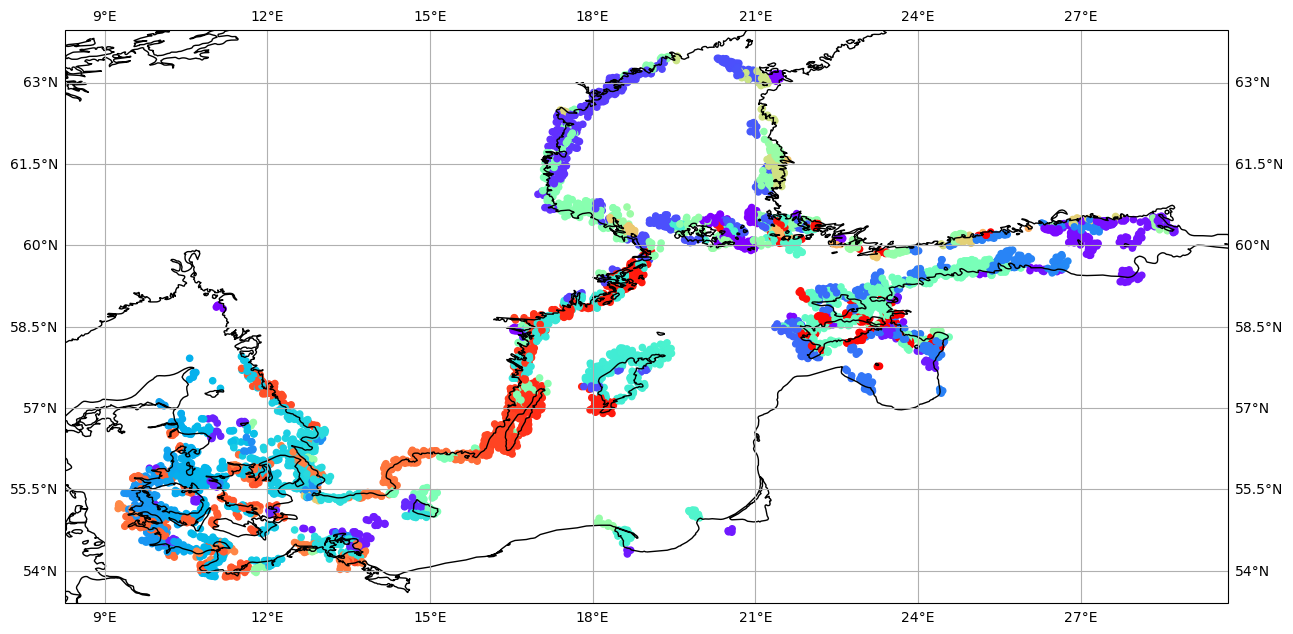

In [36]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)

ax.scatter(ds_trajectories.lon, ds_trajectories.lat, c=ds_trajectories.CellID, cmap="rainbow", s=20,)
ax.coastlines()
ax.gridlines(draw_labels=True)
# plt.xlim(19.5,21)
# plt.ylim(59.5,62)
plt.show()

In [37]:
np.dwsfa

AttributeError: module 'numpy' has no attribute 'dwsfa'

IndexError: index 90 is out of bounds for axis 1 with size 28

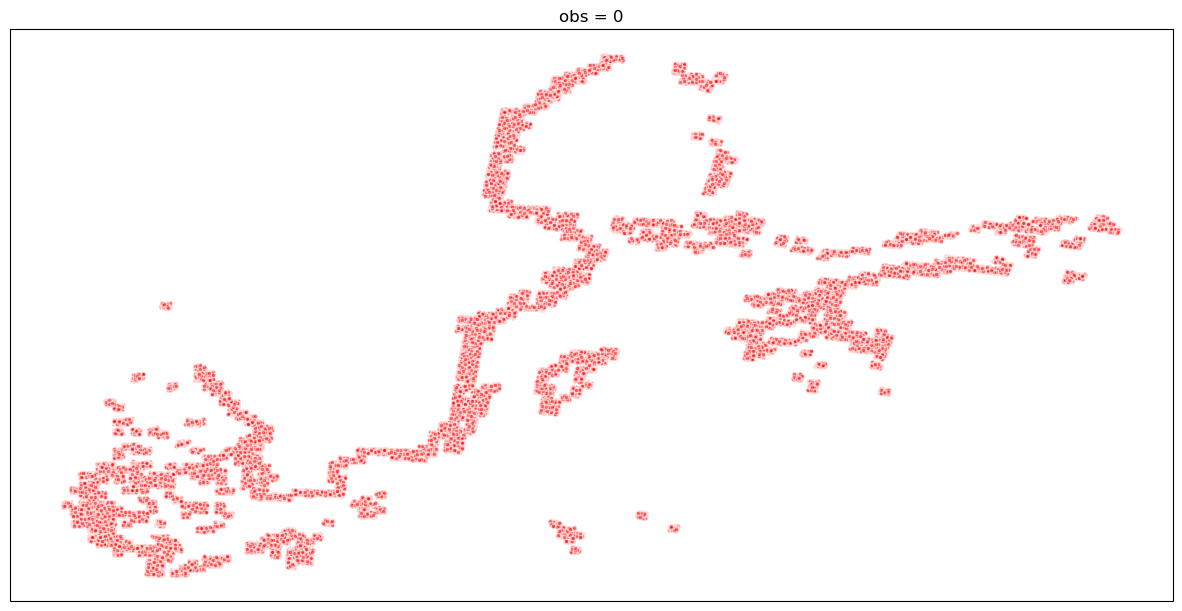

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=170).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

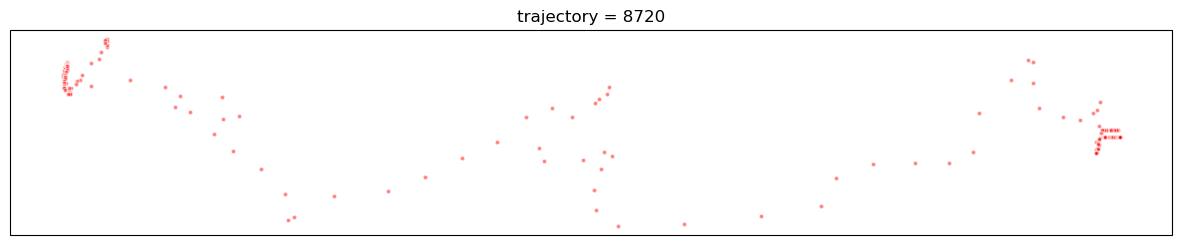

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(trajectory=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=179).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

## Time plots

In [ ]:
# for i in np.arange(ds_trajectories.trajectory.shape[0] / number_particles):
#     traj_i = int(i*number_particles)
#     plt.plot(
#         ds_trajectories.time.isel(trajectory=traj_i),
#         ds_trajectories.age_sec.isel(trajectory=traj_i) / 3600,
#     )
# plt.show()

In [ ]:
# ds_trajectories.age_day.plot()

## Maps

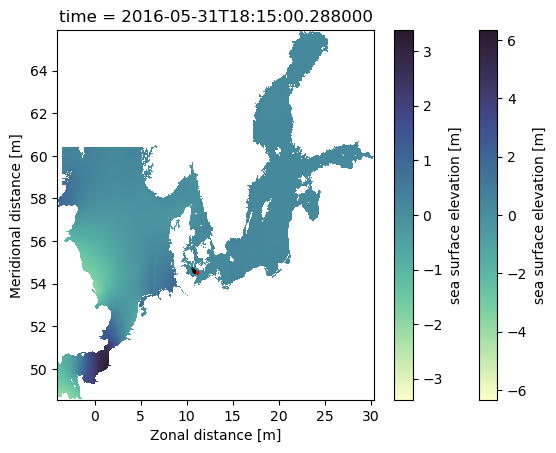

In [ ]:
# traj = ds_trajectories  # .isel(obs=671)#.isel(trajectory=6)
# # fieldset_NF
# # plt.pcolormesh(ds_eta_fine.elev.isel(time=0))
# ds_eta_fine.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )
# ds_eta_coarse.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )

# plt.scatter(
#     traj.lon,
#     traj.lat,
#     c="k",
#     s=0.00001,
# )
# plt.plot(
#     (
#         lon_release_max,
#         lon_release_max,
#         lon_release_min,
#         lon_release_min,
#         lon_release_max,
#     ),
#     (
#         lat_release_max,
#         lat_release_min,
#         lat_release_min,
#         lat_release_max,
#         lat_release_max,
#     ),
#     c="r",
# )
# # plt.xlim(7,27)
# # plt.ylim(53,60)
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.show()

In [38]:
first_lat = ds_trajectories.isel(obs=0).lat
first_lon = ds_trajectories.isel(obs=0).lon

In [39]:
last_valid_obs = ds_trajectories.obs.where(ds_trajectories.lon.notnull()).max('obs').astype(int)
last_step = ds_trajectories.isel(obs=last_valid_obs).compute()

last_lon = last_step.lon
last_lat = last_step.lat

last_step.to_dataframe().describe()

,CellID,S,T,lat,lon,obs,time,u,v,z
count,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360,4.360000e+03,4.360000e+03,4360.0
mean,50408.105469,4.544732,1.586558,57.940070,17.374971,0.459174,2016-01-01 19:07:43.335523072,-7.908708e-07,7.834759e-07,0.0
min,49699.000000,0.000000,-1.020000,53.883432,9.251812,0.000000,2016-01-01 12:00:00,-1.805364e-05,-1.516610e-06,0.0
25%,50005.000000,0.000000,0.000000,55.784186,12.585305,0.000000,2016-01-01 12:00:00,-1.425758e-06,0.000000e+00,0.0
50%,50306.000000,0.000000,0.000000,58.045505,17.480608,0.000000,2016-01-01 12:00:00,0.000000e+00,0.000000e+00,0.0
75%,50973.250000,6.312500,3.323125,59.979661,21.534707,1.000000,2016-01-02 05:44:59.712000,0.000000e+00,1.426768e-06,0.0
max,51217.000000,31.162508,6.950005,63.488371,28.739900,2.000000,2016-01-02 11:44:59.712000,1.233330e-05,1.023841e-05,0.0
std,482.363159,6.523370,2.099742,2.401346,5.066008,0.570099,NaN,1.744219e-06,1.239061e-06,0.0


In [96]:
# Read Files
data_path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
data_path_divz_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data/")
data_path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
data_path_static_fine = data_path_static_files / "static_file_fine"
data_path_static_coarse = data_path_static_files / "static_file_coarse"

sigma_file_fine = data_path_static_fine / "sigma_file_fine.nc"
H0_file_fine = data_path_static_fine / "H0_file_fine.nc"
divH0_file_fine = data_path_static_fine / "divH0_file_fine.nc"
lonlat_file_fine = data_path_static_fine / "lonlat_file_fine.nc"

z_files_fine = sorted(data_path_orig_files.glob(f"z_file_fine_{year}/*"))[first_file_count:last_file_count]

sigma_file_coarse = data_path_static_coarse / "sigma_file_coarse.nc"
H0_file_coarse = data_path_static_coarse / "H0_file_coarse.nc"
divH0_file_coarse = data_path_static_coarse / "divH0_file_coarse.nc"
lonlat_file_coarse = data_path_static_coarse / "lonlat_file_coarse.nc"

z_files_coarse = sorted(data_path_orig_files.glob(f"z_file_coarse_{year}/*"))[first_file_count:last_file_count]
# open eta and H0 files
ds_eta_fine = xr.open_dataset(z_files_fine[0])
ds_H0_fine = xr.open_dataset(H0_file_fine)

ds_eta_coarse = xr.open_dataset(z_files_coarse[0])
ds_H0_coarse = xr.open_dataset(H0_file_coarse)



In [181]:
traj_moving.time.max(skipna=True)
# traj_dead.time.max(skipna=True)

<xarray.DataArray 'time' ()> Size: 8B
array('2016-01-02T11:44:59.712000000', dtype='datetime64[ns]')

In [ ]:
traj_dead = ds_trajectories.where(first_lon == last_lon, drop=True)
traj_moving = ds_trajectories.where(first_lon != last_lon, drop=True)


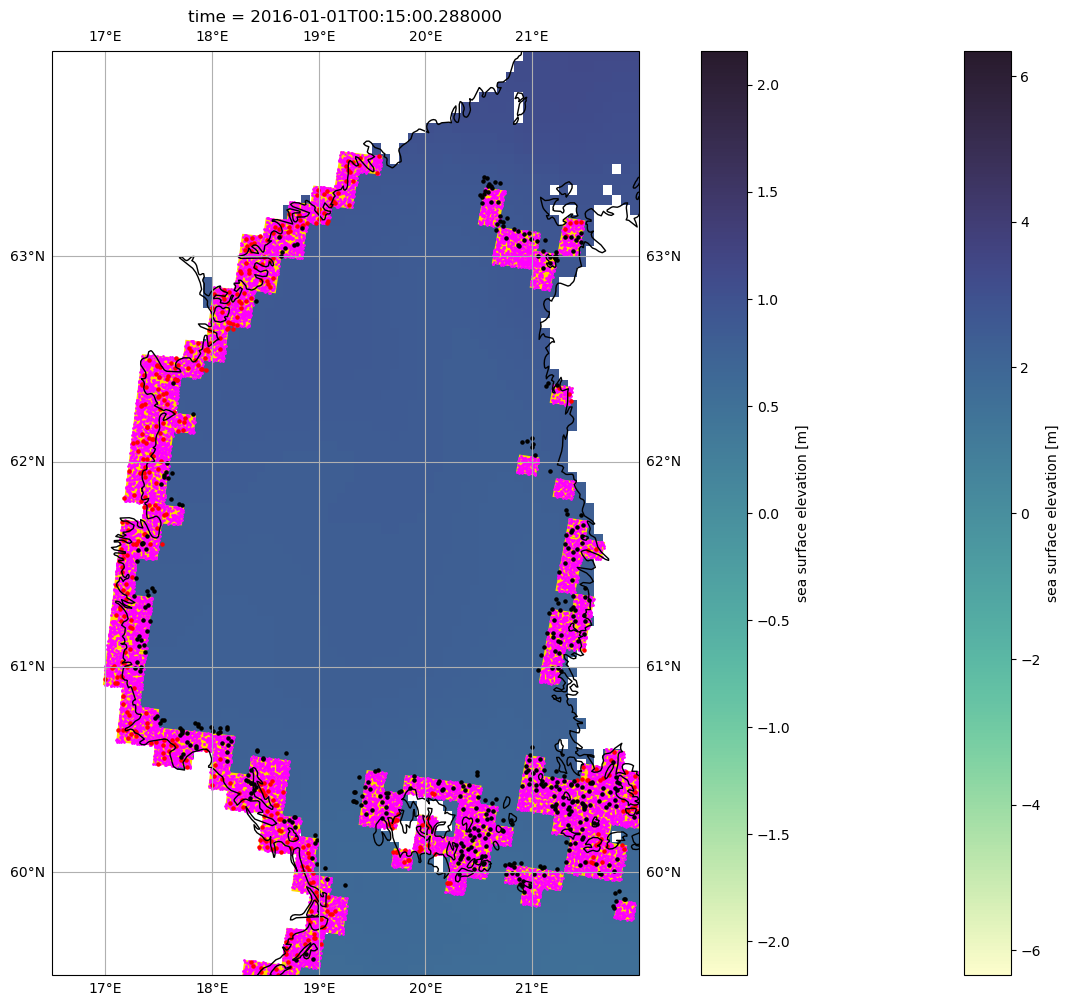

In [ ]:

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)

ds_eta_fine.elev.isel(time=0).plot(
    cmap=cmocean.cm.deep, ax=ax, 
)
ds_eta_coarse.elev.isel(time=0).plot(
    cmap=cmocean.cm.deep, ax=ax, 
)

gdf_release_area.geometry.plot(ax=ax, color="gold", alpha=1)
# ax.scatter(traj_moving.lon, traj_moving.lat, c="b", s=1)
ax.scatter(release_lons, release_lats, c="magenta", s=1)

ax.scatter(traj_dead.isel(obs=0).lon, traj_dead.isel(obs=0).lat, c="r", s=5)
ax.scatter(traj_moving.isel(obs=0).lon, traj_moving.isel(obs=0).lat, c="k", s=5)

# ax.scatter(ds_trajectories.lon, ds_trajectories.lat, c=ds_trajectories.CellID, cmap="rainbow", s=20,)
ax.coastlines()
ax.gridlines(draw_labels=True)
# plt.show_colorbar(False)
plt.xlim(16.5,22)
plt.ylim(59.5,64)
# plt.xlim(21,25)
# plt.ylim(57.5,59)
# plt.xlim(9,25)
# plt.ylim(53.5,62.5)
plt.show()

In [83]:
np.unique(ds_trajectories.isel(obs=0).CellID.values).shape

(868,)

In [144]:
ganz_tot = np.unique(traj_dead.isel(obs=0).CellID.values)[
        np.invert(
                np.in1d(
                        np.unique(traj_dead.isel(obs=0).CellID.values),
                        np.unique(traj_moving.isel(obs=0).CellID.values)
                )
        )
]

In [72]:
np.unique(traj_dead.isel(obs=0).CellID.values)
np.unique(traj_moving.isel(obs=0).CellID.values)

array([49699., 49700., 49701., 49702., 49703., 49704., 49705., 49706.,
       49707., 49710., 49711., 49712., 49713., 49714., 49715., 49717.,
       49721., 49722., 49724., 49725., 49726., 49728., 49729., 49730.,
       49731., 49732., 49734., 49735., 49736., 49738., 49739., 49740.,
       49741., 49742., 49745., 49748., 49749., 49752., 49753., 49756.,
       49757., 49758., 49759., 49760., 49764., 49766., 49769., 49780.,
       49782., 49784., 49785., 49787., 49797., 49798., 49799., 49800.,
       49802., 49806., 49807., 49808., 49818., 49825., 49826., 49829.,
       49830., 49831., 49834., 49843., 49848., 49849., 49854., 49855.,
       49856., 49857., 49858., 49859., 49864., 49870., 49872., 49873.,
       49874., 49875., 49876., 49877., 49880., 49882., 49884., 49885.,
       49894., 49900., 49901., 49908., 49909., 49910., 49911., 49912.,
       49917., 49918., 49925., 49927., 49928., 49929., 49931., 49932.,
       49935., 49939., 49940., 49941., 49942., 49943., 49944., 49946.,
      

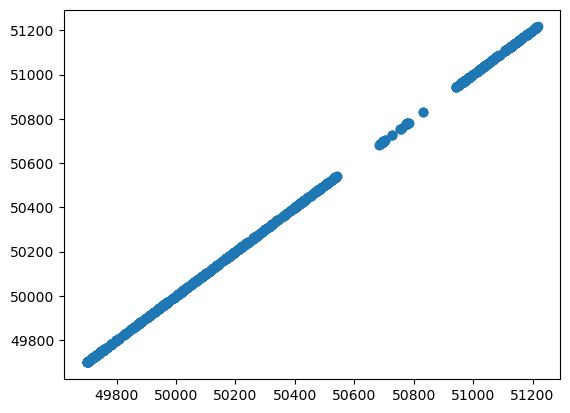

In [48]:
plt.scatter(ds_trajectories.CellID.isel(obs=0), traj_moving.CellID.isel(obs=0))

216

In [ ]:
ds_trajectories

<xarray.Dataset> Size: 4MB
Dimensions:     (trajectory: 575, obs: 124)
Coordinates:
  * obs         (obs) int32 496B 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123
  * trajectory  (trajectory) int64 5kB 1 2 6 9 12 23 ... 565 568 570 571 572 573
Data variables:
    CellID      (trajectory, obs) float32 285kB 4.971e+04 nan nan ... nan nan
    S           (trajectory, obs) float32 285kB 0.0 nan nan nan ... nan nan nan
    T           (trajectory, obs) float32 285kB 0.0 nan nan nan ... nan nan nan
    lat         (trajectory, obs) float64 570kB 60.57 nan nan ... nan nan nan
    lon         (trajectory, obs) float64 570kB 21.73 nan nan ... nan nan nan
    time        (trajectory, obs) datetime64[ns] 570kB 2016-01-01T12:00:00 .....
    u           (trajectory, obs) float32 285kB 0.0 nan nan nan ... nan nan nan
    v           (trajectory, obs) float32 285kB 0.0 nan nan nan ... nan nan nan
    z           (trajectory, obs) float64 570kB 0.0 nan nan nan ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4_2D_SIGMABSHDeleteErrorPar...
    parcels_mesh:           spherical
    parcels_version:        3.0.6

IndexError: index 27 is out of bounds for axis 1 with size 4

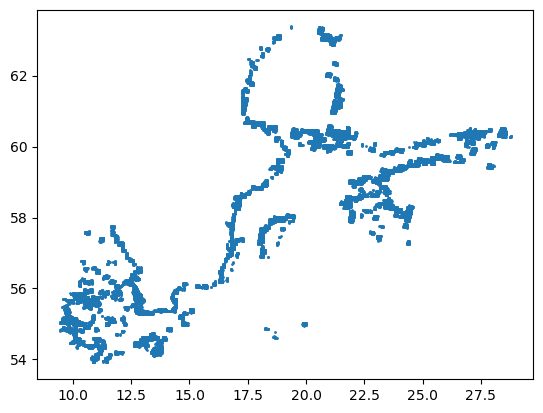

In [ ]:
plt.scatter(traj_moving.lon.isel(obs=0), traj_moving.lat.isel(obs=0), s=1)
plt.scatter(traj_moving.lon.isel(obs=1), traj_moving.lat.isel(obs=27), s=1, c="r", alpha=.5)

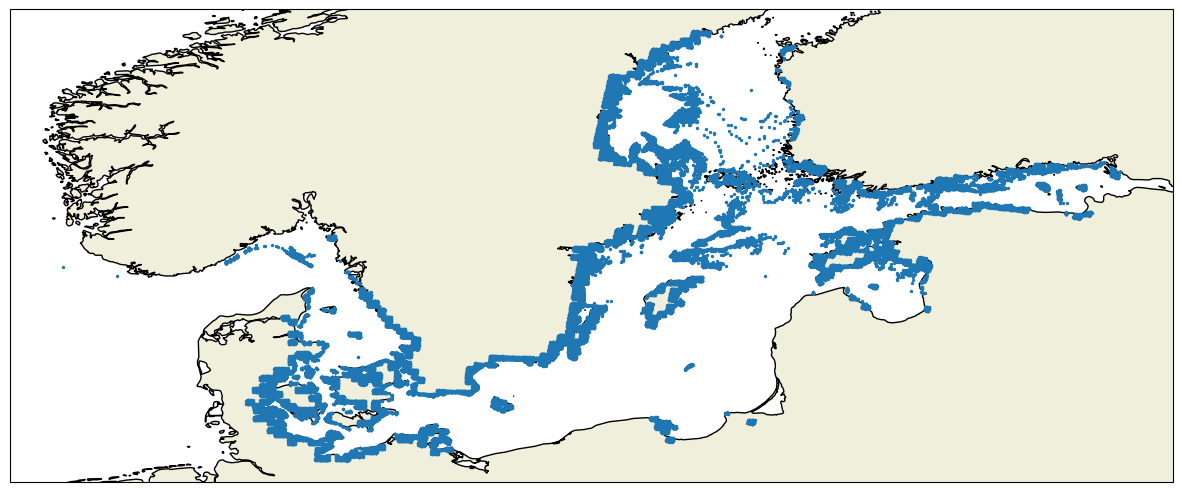

In [ ]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ax.add_feature(cartopy.feature.LAND, edgecolor='k')
ax.scatter(
    last_lon,
    last_lat,
    transform=ccrs.Geodetic(),
    s=2,
)
plt.show()

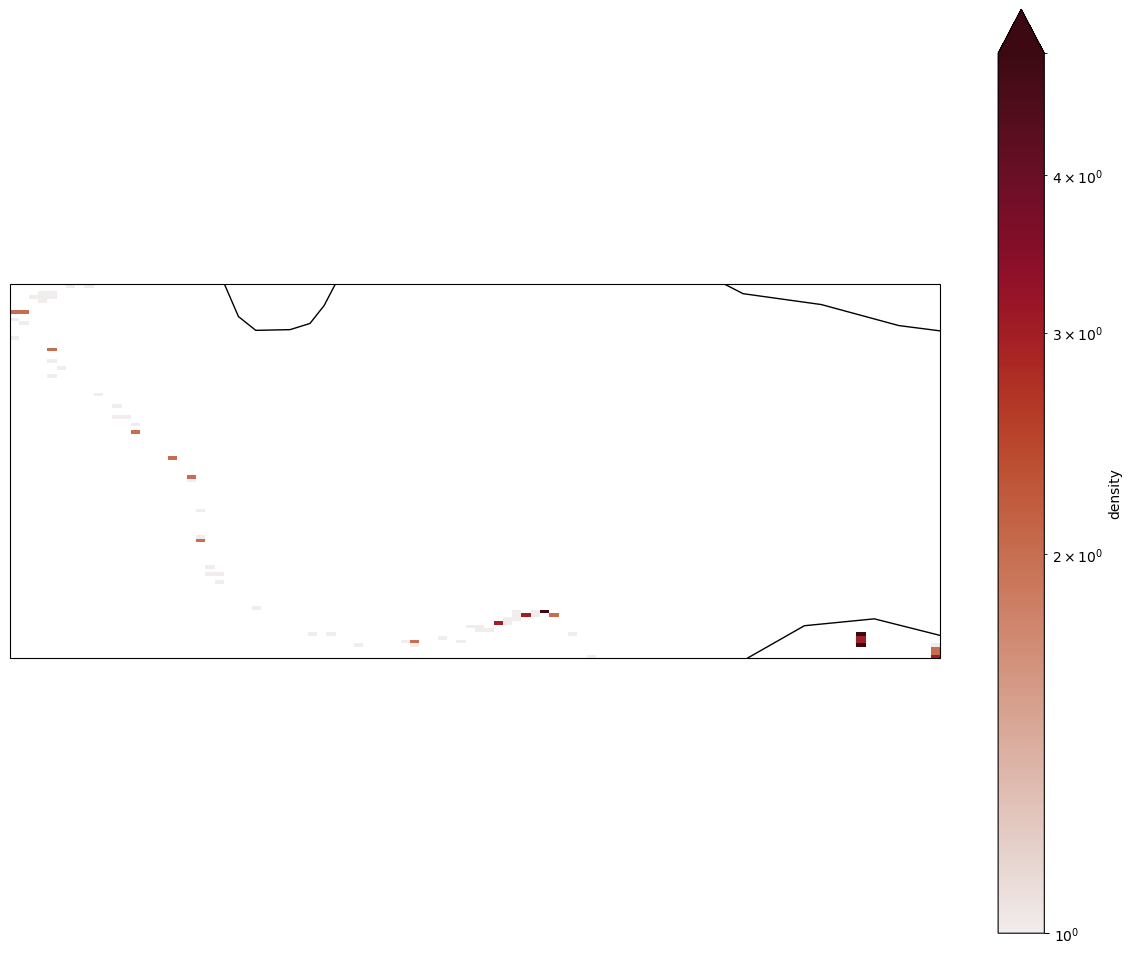

In [ ]:
fig, ax = plt.subplots(
    1,1,
    subplot_kw={'projection' : ccrs.PlateCarree()},
    figsize=(15,12),
)
ax.coastlines()
dense_plt = ax.hist2d(
    last_lon,
    last_lat,
    bins=[100, 100],
    norm=mcolors.LogNorm(),
    cmap=cmocean.cm.amp,
)
fig.colorbar(
    dense_plt[3],
    ax=ax,
    extend="max",
    label="density",
)
plt.show()